In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import lightning as L
from lightning import Trainer
import torchvision
from torch.utils.data import DataLoader, Subset
from PIL import Image
from vit_models import VisionTransformer
import torch.nn.functional as F
from torchmetrics.classification import Accuracy

In [14]:
batch_size = 100
lr = 0.01

In [3]:
compose = transforms.Compose([
# transforms.Resize(size=(384, 384), antialias=True),
transforms.ToTensor()
])
# plt.imshow(torch.permute(resize(train_dataset[index][0]), (1,2,0)).numpy())

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=compose)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=11, persistent_workers=True)

In [5]:
labels = {}
for mapping in open('/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/words.txt','r').readlines():
    maps = mapping.replace('\n','').split('\t')
    labels[maps[0]] = maps[1]

def map_labels(dataset):
    class_labels = {}
    for ind in range(0, 100000, 500):
        class_name = dataset.imgs[ind][0].split('/')[-1].split('_')[0]
        class_label = dataset[ind][1]
        class_labels[class_label] = class_name
    return class_labels

# for ind, (k,v) in enumerate(labels.items()):
#     print(k,v)
#     if ind > 10:
#         break

class_labels = map_labels(train_dataset)

for ind, (k, v) in enumerate(class_labels.items()):
    print(k, v, labels[v])
    if ind == 20:
        break

0 n01443537 goldfish, Carassius auratus
1 n01629819 European fire salamander, Salamandra salamandra
2 n01641577 bullfrog, Rana catesbeiana
3 n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
4 n01698640 American alligator, Alligator mississipiensis
5 n01742172 boa constrictor, Constrictor constrictor
6 n01768244 trilobite
7 n01770393 scorpion
8 n01774384 black widow, Latrodectus mactans
9 n01774750 tarantula
10 n01784675 centipede
11 n01855672 goose
12 n01882714 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
13 n01910747 jellyfish
14 n01917289 brain coral
15 n01944390 snail
16 n01945685 slug
17 n01950731 sea slug, nudibranch
18 n01983481 American lobster, Northern lobster, Maine lobster, Homarus americanus
19 n01984695 spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
20 n02002724 black stork, Ciconia nigra


9 n01774750 tarantula


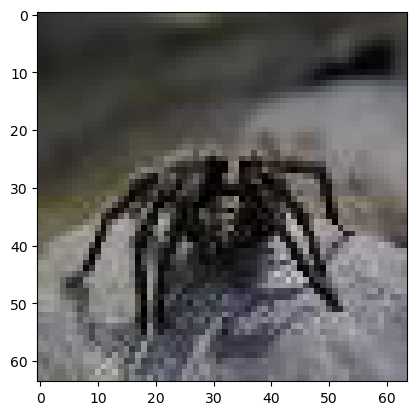

In [6]:
index = 4600
plt.imshow(torch.permute(train_dataset[index][0], (1,2,0)).numpy())
label_class = train_dataset.imgs[index][0].split('/')[-1].split('_')[0]
label_num = train_dataset[index][1]
print(label_num, label_class, labels[class_labels[label_num]])
# class_name = class_labels[labels[label_num]]

In [15]:
custom_config = {
        "img_size": 64,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 6,
        "n_heads": 8,
        "qkv_bias": True,
        "mlp_ratio": 4,
        "n_classes":200
}

In [18]:
class VisionTransformerWrapper(L.LightningModule):
    
    def __init__(self, model, **kvargs):
        super(VisionTransformerWrapper, self).__init__()
        self.model = model(**kvargs)
        self.accuracy = Accuracy(task="multiclass", num_classes=200)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        # print(images.shape)
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        self.accuracy(outputs, labels)
        
        self.log('train_acc_step', self.accuracy)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=lr)
        
    def train_dataloader(self):
       train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=compose)
       train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=11, persistent_workers=True)
       return train_loader

[rank: 0] Received SIGTERM: 15


In [17]:
trainer = Trainer(max_epochs = 10, fast_dev_run=False)
model = VisionTransformerWrapper(VisionTransformer, **custom_config)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/ykamoji/Documents/Learning/ViT/BasicViT/lightning_logs

  | Name     | Type               | Params
------------------------------------------------
0 | model    | VisionTransformer  | 43.3 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
43.3 M    Trainable params
0         Non-trainable params
43.3 M    Total params
173.148   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/Users/ykamoji/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model.eval()

In [ ]:
img = train_dataset[0][0]
# img = (np.array(img) / 128) - 1  # in the range -1, 1
print(img.shape)
logits = model(img.unsqueeze(0).to(torch.float32))
# print(logits)
probs = torch.nn.functional.softmax(logits, dim=-1)
top_probs, top_ixs = probs[0].topk(5)
# print(f"\n{image}")
for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    cls = labels[class_labels[ix]]
    print(f"{i}: {cls:<45} --- {prob:.4f}")

In [ ]:
torch.mps.empty_cache()